model parameters: [1675, 3342, 8700, 17570, 41435]
epoch 1/50
epoch 2/50
epoch 3/50
epoch 4/50
epoch 5/50
epoch 6/50
epoch 7/50
epoch 8/50
epoch 9/50
epoch 10/50
epoch 11/50
epoch 12/50
epoch 13/50
epoch 14/50
epoch 15/50
epoch 16/50
epoch 17/50
epoch 18/50
epoch 19/50
epoch 20/50
epoch 22/50
epoch 23/50
epoch 24/50
epoch 25/50
epoch 26/50
epoch 27/50
epoch 28/50
epoch 29/50
epoch 30/50
epoch 31/50
epoch 32/50
epoch 33/50
epoch 34/50
epoch 35/50
epoch 36/50
epoch 37/50
epoch 38/50
epoch 39/50
epoch 40/50
epoch 41/50
epoch 42/50
epoch 43/50
epoch 44/50
epoch 45/50
epoch 46/50
epoch 47/50
epoch 48/50
epoch 49/50
epoch 50/50


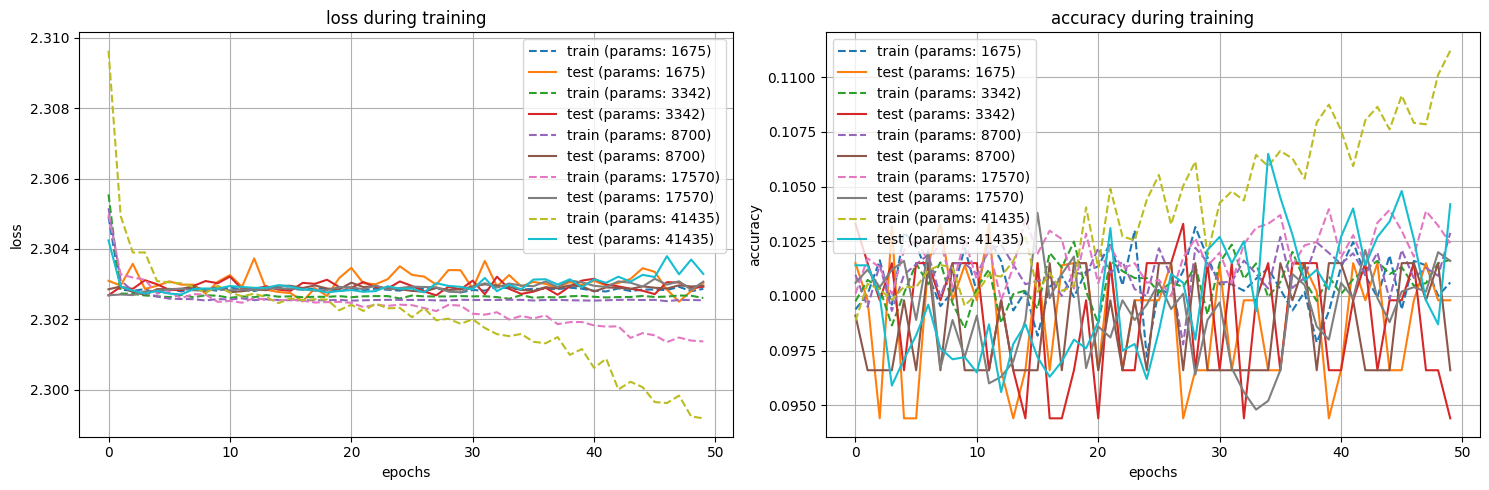

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# get mnist data for experiments
# we'll randomize labels to test if networks can memorize random stuff
train_data = datasets.MNIST('./MNIST', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.MNIST('./MNIST', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# mix up all the labels randomly
# this makes the task impossible but tests pure memorization ability
random_train_labels = torch.tensor(np.random.randint(0, 10, len(train_data)))
train_data.targets = random_train_labels
random_test_labels = torch.tensor(np.random.randint(0, 10, len(test_data)))
test_data.targets = random_test_labels

# create data loaders with different batch sizes
# different batch sizes affect how models learn and generalize
batch_list = [5, 25, 125, 500, 1500]
train_loaders = [torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True) for bs in batch_list]
test_loaders = [torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True) for bs in batch_list]

# simple neural network that we can resize
# we test different sizes to see how parameters affect learning
class Net(nn.Module):
    def __init__(self, h1=256, h2=128):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, h1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(h2, h2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(h2, 10)
        )
    
    def forward(self, x):
        return self.layers(x)

# make models with different sizes
# each model has different number of parameters to test size effects
sizes = [(2, 5), (4, 8), (10, 20), (20, 30), (50, 25)]
models = [Net(h1, h2) for h1, h2 in sizes]

def count_params(model):
    # count total parameters in the model
    # helps us compare models with different architectures
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

param_counts = [count_params(model) for model in models]
print(f"model parameters: {param_counts}")

# setup training components
# we use same loss function and optimizer for fair comparison
loss_fn = nn.CrossEntropyLoss()
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

# train all models and track performance
# we want to see how different sizes perform on impossible task
epochs = 50
train_losses = [[] for _ in models]
test_losses = [[] for _ in models]
train_accs = [[] for _ in models]
test_accs = [[] for _ in models]

for epoch in range(epochs):
    print(f"epoch {epoch + 1}/{epochs}")

    for model, optimizer, train_loader, test_loader, model_train_loss, model_test_loss, model_train_acc, model_test_acc in zip(
        models, optimizers, train_loaders, test_loaders, train_losses, test_losses, train_accs, test_accs):
        
        # training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.view(-1, 784)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += len(labels)
            
        model_train_loss.append(total_train_loss / len(train_loader))
        model_train_acc.append(correct_train / total_train)

        # testing phase
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.view(-1, 784)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()
                correct_test += (outputs.argmax(dim=1) == labels).sum().item()
                total_test += len(labels)
                
        model_test_loss.append(total_test_loss / len(test_loader))
        model_test_acc.append(correct_test / total_test)

# plot training results
# first plot shows how loss changes during training
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, params in enumerate(param_counts):
    plt.plot(range(epochs), train_losses[i], '--', label=f"train (params: {params})")
    plt.plot(range(epochs), test_losses[i], '-', label=f"test (params: {params})")
plt.title("loss during training")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, params in enumerate(param_counts):
    plt.plot(range(epochs), train_accs[i], '--', label=f"train (params: {params})")
    plt.plot(range(epochs), test_accs[i], '-', label=f"test (params: {params})")
plt.title("accuracy during training")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

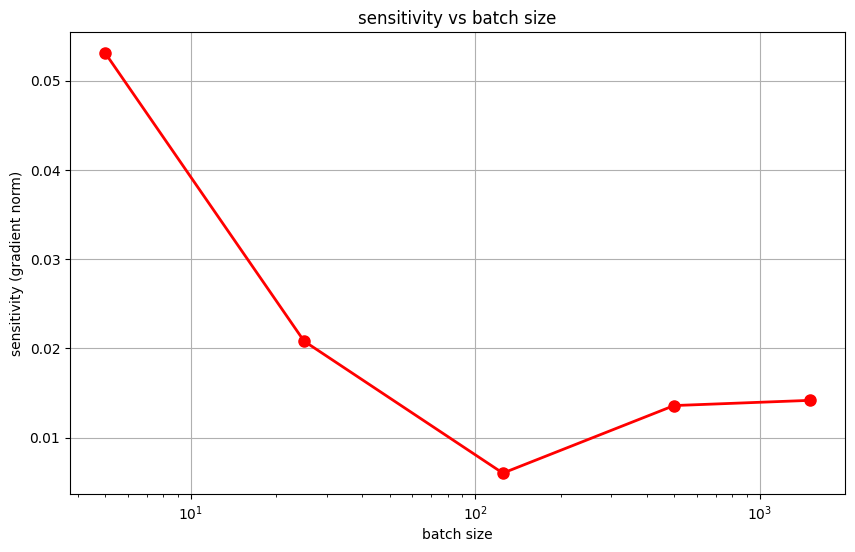

In [5]:
# calculate sensitivity for each model
# this measures how much gradients vary with different training conditions
sensitivities = []
for model in models:
    total_grad = 0
    param_count = 0
    
    for param in model.parameters():
        if param.grad is not None:
            total_grad += torch.linalg.norm(param.grad).item()
            param_count += 1
            
    avg_sensitivity = total_grad / param_count if param_count > 0 else 0
    sensitivities.append(avg_sensitivity)

# plot sensitivity vs batch size
# this shows how batch size affects gradient behavior
plt.figure(figsize=(10, 6))
plt.plot(batch_list, sensitivities, 'ro-', linewidth=2, markersize=8)
plt.title("sensitivity vs batch size")
plt.xlabel("batch size")
plt.ylabel("sensitivity (gradient norm)")
plt.xscale("log")
plt.grid(True)
plt.show()

In [6]:
# print final results
for i, params in enumerate(param_counts):
    final_train = train_accs[i][-1]
    final_test = test_accs[i][-1]
    print(f"model {i+1} ({params} params): train={final_train:.3f}, test={final_test:.3f}")

model 1 (1675 params): train=0.101, test=0.100
model 2 (3342 params): train=0.102, test=0.094
model 3 (8700 params): train=0.103, test=0.097
model 4 (17570 params): train=0.102, test=0.102
model 5 (41435 params): train=0.111, test=0.104
